In [1]:
pip install streamlit

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
dff = pd.read_csv('/content/ABBREV.csv')
df= dff

In [4]:
df.fillna(0, inplace=True)
X = df.drop(['index', 'NDB_No', 'Shrt_Desc', 'GmWt_Desc1', 'GmWt_Desc2'], axis=1).values

we will preprocess the dataset and extract the clusters using an Autoencoder

In [5]:
# Feature Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Autoencoder
from keras.layers import Input, Dense
from keras.models import Model

# Set the encoding dimension
encoding_dim = 3

# Input layer
input_layer = Input(shape=(X.shape[1],))

# Encoder layers
encoder = Dense(encoding_dim, activation='relu')(input_layer)

# Decoder layers
decoder = Dense(X.shape[1], activation='softmax')(encoder)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=16, shuffle=True, validation_split=0.2)

Epoch 1/50
440/440 [==============================] - 2s 3ms/step - loss: 0.0136 - accuracy: 0.5779 - val_loss: 0.0083 - val_accuracy: 0.6342
Epoch 2/50
440/440 [==============================] - 1s 2ms/step - loss: 0.0083 - accuracy: 0.7069 - val_loss: 0.0068 - val_accuracy: 0.6342
Epoch 3/50
440/440 [==============================] - 2s 5ms/step - loss: 0.0071 - accuracy: 0.7069 - val_loss: 0.0062 - val_accuracy: 0.6342
Epoch 4/50
440/440 [==============================] - 2s 5ms/step - loss: 0.0064 - accuracy: 0.7149 - val_loss: 0.0056 - val_accuracy: 0.7093
Epoch 5/50
440/440 [==============================] - 2s 4ms/step - loss: 0.0059 - accuracy: 0.8094 - val_loss: 0.0050 - val_accuracy: 0.8663
Epoch 6/50
440/440 [==============================] - 2s 4ms/step - loss: 0.0055 - accuracy: 0.8585 - val_loss: 0.0045 - val_accuracy: 0.8709
Epoch 7/50
440/440 [==============================] - 2s 4ms/step - loss: 0.0051 - accuracy: 0.8687 - val_loss: 0.0038 - val_accuracy: 0.8965
Epoch 

After training the autoencoder, we can extract the encoded features:

In [6]:
# Extract encoded features
encoder = Model(inputs=input_layer, outputs=encoder)
encoded_features = encoder.predict(X_scaled)

275/275 [==============================] - 0s 1ms/step


Now, we can apply K-means clustering to group the samples into three clusters:

In [7]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(encoded_features)
clusters = kmeans.predict(encoded_features)

high_caloric = encoded_features[clusters == 0]
mid_caloric = encoded_features[clusters == 1]
low_caloric = encoded_features[clusters == 2]
df['cluster'] = clusters

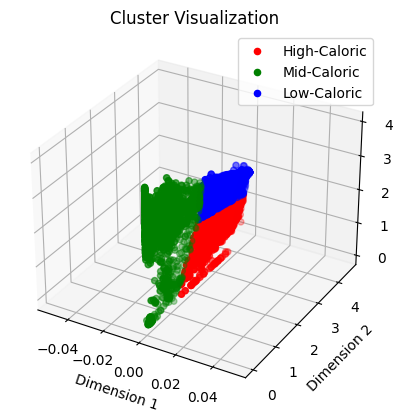

In [8]:
# Visualize the clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the high-caloric food cluster
ax.scatter(high_caloric[:, 0], high_caloric[:, 1], high_caloric[:, 2], c='r', label='High-Caloric')

# Plot the mid-caloric food cluster
ax.scatter(mid_caloric[:, 0], mid_caloric[:, 1], mid_caloric[:, 2], c='g', label='Mid-Caloric')

# Plot the low-caloric food cluster
ax.scatter(low_caloric[:, 0], low_caloric[:, 1], low_caloric[:, 2], c='b', label='Low-Caloric')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

ax.legend()
plt.title('Cluster Visualization')
plt.show()

In [9]:
encoded_features

array([[0.        , 0.8870088 , 0.38101453],
       [0.        , 0.9309974 , 0.4871865 ],
       [0.        , 0.11003852, 0.07409137],
       ...,
       [0.        , 0.3203851 , 3.3784225 ],
       [0.        , 4.1031094 , 1.4793952 ],
       [0.        , 4.1973786 , 1.2519727 ]], dtype=float32)

Next, we can generate the right food diets using Particle Swarm Optimization (PSO) for the CNN model:

In [10]:
pip install pyswarms

In [11]:
import pyswarms as ps

In [12]:
X = X
y = df['cluster'].values
from sklearn.svm import LinearSVC
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def calculate_fitness(position, X, y):
    selected_features = position >= 0.5
    print('Shape of selected_features:', selected_features.shape)
    X_selected = X[:, selected_features.shape[0]]
    clf = LinearSVC()
    score = np.mean(cross_val_score(clf, X_selected.reshape(-1,1), y, cv=5))
    return score

def pso_feature_selection(X, y, num_particles, num_iterations):
    num_features = X.shape[1]
    options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
    dimensions = num_features

    optimizer = ps.single.GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options)

    cost, pos = optimizer.optimize(calculate_fitness, iters=num_iterations, X=X, y=y)

    selected_features = pos >= 0.5
    X_selected = X[:, selected_features]

    return X_selected

num_particles = encoded_features.shape[1]  # Update num_particles to match the number of features
X_selected = pso_feature_selection(X, y, num_particles=num_particles, num_iterations=20)

2023-07-25 16:25:27,434 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/20

Shape of selected_features: (3, 49)


pyswarms.single.global_best:   5%|▌         |1/20, best_cost=0.551

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  10%|█         |2/20, best_cost=0.551

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  15%|█▌        |3/20, best_cost=0.551

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  20%|██        |4/20, best_cost=0.551

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  25%|██▌       |5/20, best_cost=0.551

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  30%|███       |6/20, best_cost=0.551

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  35%|███▌      |7/20, best_cost=0.55

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  40%|████      |8/20, best_cost=0.55

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  45%|████▌     |9/20, best_cost=0.55

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  50%|█████     |10/20, best_cost=0.55

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  55%|█████▌    |11/20, best_cost=0.55

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  60%|██████    |12/20, best_cost=0.55

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  65%|██████▌   |13/20, best_cost=0.55

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  70%|███████   |14/20, best_cost=0.55

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  75%|███████▌  |15/20, best_cost=0.549

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  80%|████████  |16/20, best_cost=0.549

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  85%|████████▌ |17/20, best_cost=0.549

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  90%|█████████ |18/20, best_cost=0.549

Shape of selected_features: (3, 49)


pyswarms.single.global_best:  95%|█████████▌|19/20, best_cost=0.549

Shape of selected_features: (3, 49)


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=0.542
2023-07-25 16:27:01,898 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5418657565415245, best pos: [ 1.2698253   0.87417898  0.87515026  0.83960852 -0.08368427 -0.03476799
  0.6024447   0.47560104  0.56551636  0.18058041  0.20141685  1.83430359
 -0.24875583  0.03105186  0.09412948  0.3479243   0.46132977  1.58040491
  0.25283028  0.09737592  0.8666248   0.23370329  0.7456103   0.2627895
  0.32382136  0.04217892  0.26979836  0.95412506  0.31831595  0.39793357
  0.49630981  0.42320701  1.06121298  0.59117953 -0.26310383  0.36097524
  0.48238516  0.2500114   0.35038452  0.09302147  0.78368703  0.47218802
  0.53807695 -0.57758972 -0.11740653  0.51046094  0.79068768  0.86316908
  0.49482877]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
# Reshape the data for compatibility with CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [14]:
y.shape

(8790,)

In [15]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.utils import to_categorical

# Train the CNN model
# ...

# Encode target labels as one-hot vectors
num_classes = 3
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

# Build the CNN model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=10, batch_size=64, validation_data=(X_test, y_test_encoded))

Epoch 1/10
110/110 [==============================] - 4s 19ms/step - loss: 2.2276 - accuracy: 0.7996 - val_loss: 0.9340 - val_accuracy: 0.8874
Epoch 2/10
110/110 [==============================] - 1s 6ms/step - loss: 0.9579 - accuracy: 0.9016 - val_loss: 2.4841 - val_accuracy: 0.8868
Epoch 3/10
110/110 [==============================] - 1s 6ms/step - loss: 0.5798 - accuracy: 0.9174 - val_loss: 0.3434 - val_accuracy: 0.9408
Epoch 4/10
110/110 [==============================] - 1s 8ms/step - loss: 0.2179 - accuracy: 0.9396 - val_loss: 0.3765 - val_accuracy: 0.9403
Epoch 5/10
110/110 [==============================] - 1s 10ms/step - loss: 0.2002 - accuracy: 0.9468 - val_loss: 0.2889 - val_accuracy: 0.9465
Epoch 6/10
110/110 [==============================] - 1s 10ms/step - loss: 0.1587 - accuracy: 0.9494 - val_loss: 0.1684 - val_accuracy: 0.9482
Epoch 7/10
110/110 [==============================] - 2s 14ms/step - loss: 0.1671 - accuracy: 0.9468 - val_loss: 0.2290 - val_accuracy: 0.9534
Ep

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Evaluate the model on the test data
from keras.utils import to_categorical

# Encode target labels as one-hot vectors
num_classes = 3
y_test_encoded = to_categorical(y_test, num_classes)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {accuracy:.4f}")

55/55 [==============================] - 0s 3ms/step - loss: 0.2168 - accuracy: 0.9482
Test Accuracy: 0.9482


In [17]:
y_pred = model.predict(X_test)

55/55 [==============================] - 0s 3ms/step


In [18]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_selected)
best_clusters = kmeans.predict(X_selected)
df['cluster1'] = best_clusters
high_caloric1 = df[best_clusters == 0]
mid_caloric1 = df[best_clusters == 1]
low_caloric1 = df[best_clusters == 2]

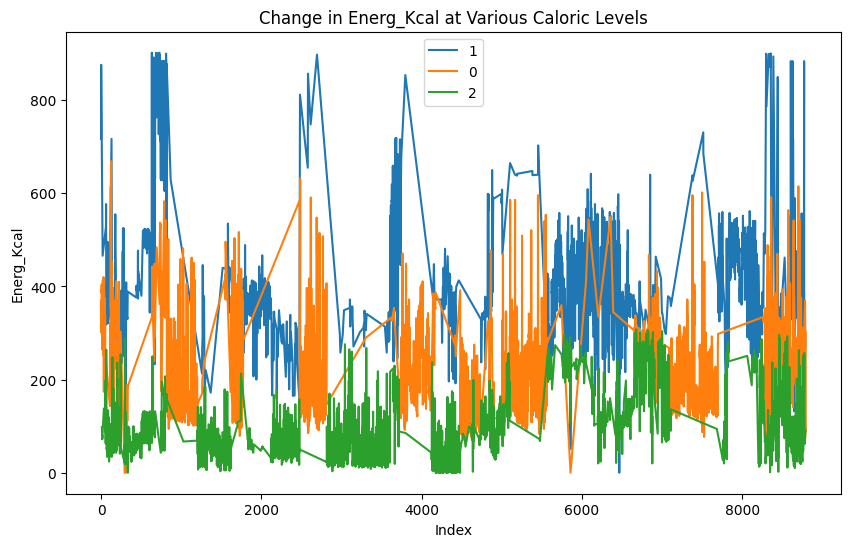

In [19]:
import matplotlib.pyplot as plt

# Select the columns of interest
columns_to_visualize = ['Energ_Kcal', 'cluster']

# Get the subset of the DataFrame for the selected columns
subset = df[columns_to_visualize]

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the line plot
for caloric_level in subset['cluster'].unique():
    level_data = subset[subset['cluster'] == caloric_level]
    plt.plot(level_data.index, level_data['Energ_Kcal'], label=caloric_level)

plt.xlabel('Index')
plt.ylabel('Energ_Kcal')
plt.title('Change in Energ_Kcal at Various Caloric Levels')
plt.legend()

# Show the plot
plt.show()

Recommendation system

In [20]:
import random

In [21]:
from sklearn.preprocessing import LabelEncoder
# Define the categorical labels
categories = {2: 'low', 1: 'mid', 0: 'high'}

# Map the numerical values to categorical labels
df['caloric level'] = df['cluster1'].map(categories)

# Print the DataFrame with the new categorical column
df.columns

Index(['index', 'NDB_No', 'Shrt_Desc', 'Water_(g)', 'Energ_Kcal',
       'Protein_(g)', 'Lipid_Tot_(g)', 'Ash_(g)', 'Carbohydrt_(g)',
       'Fiber_TD_(g)', 'Sugar_Tot_(g)', 'Calcium_(mg)', 'Iron_(mg)',
       'Magnesium_(mg)', 'Phosphorus_(mg)', 'Potassium_(mg)', 'Sodium_(mg)',
       'Zinc_(mg)', 'Copper_mg)', 'Manganese_(mg)', 'Selenium_(µg)',
       'Vit_C_(mg)', 'Thiamin_(mg)', 'Riboflavin_(mg)', 'Niacin_(mg)',
       'Panto_Acid_mg)', 'Vit_B6_(mg)', 'Folate_Tot_(µg)', 'Folic_Acid_(µg)',
       'Food_Folate_(µg)', 'Folate_DFE_(µg)', 'Choline_Tot_ (mg)',
       'Vit_B12_(µg)', 'Vit_A_IU', 'Vit_A_RAE', 'Retinol_(µg)',
       'Alpha_Carot_(µg)', 'Beta_Carot_(µg)', 'Beta_Crypt_(µg)',
       'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)', 'Vit_D_µg', 'Vit_D_IU',
       'Vit_K_(µg)', 'FA_Sat_(g)', 'FA_Mono_(g)', 'FA_Poly_(g)',
       'Cholestrl_(mg)', 'GmWt_1', 'GmWt_Desc1', 'GmWt_2', 'GmWt_Desc2',
       'Refuse_Pct', 'cluster', 'cluster1', 'caloric level'],
      dtype='object')

In [22]:
df.to_csv("C:\\Users\\t\\Downloads\\Diet recommendation\\data for recommendation.csv")

In [45]:
def recommend_diets(caloric_level,caloric_value , n=10):
    # Filter the dataset based on the caloric level
    filtered_data = df[df['caloric level'] == caloric_level]

    # Sort the diets based on some criteria (e.g., nutrients)
    sorted_diets = filtered_data.sort_values(by=['Energ_Kcal'], ascending=False)

    # Return the top n recommended diets
    dff = sorted_diets
    recommended_diets = dff[(dff['Energ_Kcal'] >= caloric_value) & (dff['Energ_Kcal'] <= caloric_value + 100)]

    return recommended_diets.head(n)

# Example usage:
top_10_diets_low_calorie = recommend_diets('low', 120,  n=5)
top_10_diets_mid_calorie = recommend_diets('mid', 300, n=10)
top_10_diets_high_calorie = recommend_diets('high', 800, n=5)

In [46]:
top_10_diets_high_calorie[['Shrt_Desc', 'Energ_Kcal']].set_index(
    [pd.Index(['student-1', 'student-2', 'student-3', 'student-4', '5'])])

,Shrt_Desc,Energ_Kcal
student-1,"SHORTENING FRYING (HVY DUTY),BF TALLOW&CTTNSD",900
student-2,"OIL,WALRUS (ALASKA NATIVE)",900
student-3,"OIL,BELUGA,WHALE (ALASKA NATIVE)",900
student-4,"FAT,GOOSE",900
5,"FAT,TURKEY",900


Code for pregnancy woman input

In [25]:
def nutrients(age, height, weight, preg_stage, active):
    if active.lower() == 'sedentary':
        active = 1.2
    elif active.lower() == "light active":
        active = 1.375
    elif active.lower() == "moderately active":
        active = 1.55
    elif active.lower() == "very active":
        active = 1.75

    bmi = weight / (height * height)
    if bmi < 18.5:
        person = 'Underweight'
        if preg_stage.lower() == "firsttrimester":
            goal = 2
        elif preg_stage.lower() == "secondtrimester":
            goal = 10
        elif preg_stage.lower() == "thirdtrimester":
            goal = 18
    elif bmi >= 18.5 and bmi <= 25:
        person = 'Health in Weight'
        if preg_stage.lower() == "firsttrimester":
            goal = 2
        elif preg_stage.lower() == "secondtrimester":
            goal = 10
        elif preg_stage.lower() == "thirdtrimester":
            goal = 16
    elif bmi > 25:
        person = 'Overweight'
        if preg_stage.lower() == "firsttrimester":
            goal = 2
        elif preg_stage.lower() == "secondtrimester":
            goal = 7
        elif preg_stage.lower() == "thirdtrimester":
            goal = 11

    # Mifflin-St Jeor BMR equation to get the BMR formula
    bmr = 10 * weight + 6.25 * height - 5 * age - 161

    # Needed calories = BMR multiplied by the activity level
    caloric_intake = bmr * float(active)

    return caloric_intake

def classify_caloric_intake(caloric_intake):
    if caloric_intake < 300:
        classification = "low"
    elif caloric_intake >= 300 and caloric_intake <= 350:
        classification = "mid"
    else:
        classification = "high"

    return classification

In [32]:
# Collect user input
age = int(input("Enter your age in years: "))
height = float(input("Enter your height in meters: "))
weight = float(input("Enter your weight in kilograms: "))
preg_stage = input("Enter your pregnancy stage (FirstTrimester, SecondTrimester, ThirdTrimester): ")
active = input("Enter your activity level (Sedentary, Light Active, Moderately Active, Very Active): ")

# Calculate caloric intake
caloric_intake = nutrients(age, height, weight, preg_stage, active)

# Classify caloric intake
caloric_classification = classify_caloric_intake(caloric_intake)
# Display the result
print("Your recommended caloric intake is:", caloric_intake, "calories per day.")
print("Caloric Intake Classification:", caloric_classification)
result = recommend_diets(caloric_classification, caloric_intake, n=5)
print(result[['Shrt_Desc', 'Energ_Kcal']].to_string(index=False))

Enter your age in years: 34
Enter your height in meters: 1.4
Enter your weight in kilograms: 54
Enter your pregnancy stage (FirstTrimester, SecondTrimester, ThirdTrimester): SecondTrimester
Enter your activity level (Sedentary, Light Active, Moderately Active, Very Active): Light Active
Your recommended caloric intake is: 299.40625 calories per day.
Caloric Intake Classification: low
Empty DataFrame
Columns: [Shrt_Desc, Energ_Kcal]
Index: []


In [27]:
pip install dill

DEFINING THE FUNCTIONS IN A CLASS

In [28]:
class DietRecommendation:

    def recommend_diets(self, caloric_level, caloric_value, n=10):
        # Filter the dataset based on the caloric level
        filtered_data = self.df[self.df['caloric level'] == caloric_level]

        # Sort the diets based on some criteria (e.g., nutrients)
        sorted_diets = filtered_data.sort_values(by=['Energ_Kcal'], ascending=False)

        # Return the top n recommended diets
        dff = sorted_diets
        recommended_diets = dff[(dff['Energ_Kcal'] >= caloric_value) & (dff['Energ_Kcal'] <= caloric_value + 100)]

        return recommended_diets.head(n)

    def nutrients(self, age, height, weight, preg_stage, active):
        if active.lower() == 'sedentary':
            active = 1.2
        elif active.lower() == "light active":
            active = 1.375
        elif active.lower() == "moderately active":
            active = 1.55
        elif active.lower() == "very active":
            active = 1.75

        bmi = weight / (height * height)
        if bmi < 18.5:
            person = 'Underweight'
            if preg_stage.lower() == "firsttrimester":
                goal = 2
            elif preg_stage.lower() == "secondtrimester":
                goal = 10
            elif preg_stage.lower() == "thirdtrimester":
                goal = 18
        elif bmi >= 18.5 and bmi <= 25:
            person = 'Health in Weight'
            if preg_stage.lower() == "firsttrimester":
                goal = 2
            elif preg_stage.lower() == "secondtrimester":
                goal = 10
            elif preg_stage.lower() == "thirdtrimester":
                goal = 16
        elif bmi > 25:
            person = 'Overweight'
            if preg_stage.lower() == "firsttrimester":
                goal = 2
            elif preg_stage.lower() == "secondtrimester":
                goal = 7
            elif preg_stage.lower() == "thirdtrimester":
                goal = 11

        # Mifflin-St Jeor BMR equation to get the BMR formula
        bmr = 10 * weight + 6.25 * height - 5 * age - 161

        # Needed calories = BMR multiplied by the activity level
        caloric_intake = bmr * float(active)

        return caloric_intake

    def classify_caloric_intake(self, caloric_intake):
        if caloric_intake < 300:
            classification = "low"
        elif caloric_intake >= 300 and caloric_intake <= 350:
            classification = "mid"
        else:
            classification = "high"

        return classification


In [31]:
import dill as pickle
# Create an instance of the DietRecommendation class
diet_recommendation = DietRecommendation()
# Pickle the DietRecommendation instance to a file
#with open('diet_recommendation.pkl', 'wb') as file:
 #   pickle.dump(diet_recommendation, file)

def pickle_function(func, filename):
    with open(filename, 'wb') as file:
        pickle.dump(func, file)
pickle_function(diet_recommendation.recommend_diets, 'recommend_function.pka')
pickle_function(diet_recommendation.nutrients, 'nutrient.pkbb')
pickle_function(diet_recommendation.classify_caloric_intake, 'classify_caloric_intake.pkc')